# Dimensionality Reduction - SVD II

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import slideUtilities as sl
import laUtilities as ut
import seaborn as sns
from importlib import reload
from datetime import datetime
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
print('')

In [2]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

In the last lecture we learned about the SVD as a tool for constructing low-rank matrices.

Today we'll look at it as a way to transform our data objects.

As a reminder, here is what the SVD looks like:

$$ \mbox{objects}\left\{\begin{array}{c}\;\\\;\\\;\\\;\\\;\end{array}\right.\;\;\overbrace{\left[\begin{array}{cccc}\begin{array}{c}\vdots\\\vdots\\{\bf a_1}\\\vdots\\\vdots\end{array}&\begin{array}{c}\vdots\\\vdots\\{\bf a_2}\\\vdots\\\vdots\end{array}&\dots&\begin{array}{c}\vdots\\\vdots\\{\bf a_n}\\\vdots\\\vdots\end{array}\\\end{array}\right]}^{\mbox{features}} =
\overbrace{\left[\begin{array}{cc}\vdots&\vdots\\\vdots&\vdots\\\sigma_1\vu_1&\sigma_k\vu_k\\\vdots&\vdots\\\vdots&\vdots\end{array}\right]}^{\large k}
\times
\left[\begin{array}{ccccc}\dots&\dots&\vv_1&\dots&\dots\\\dots&\dots&\vv_k&\dots&\dots\end{array}\right]$$


$$ A = U\Sigma V^T$$

Notice that $U$ contains a row for each object.   

In a sense we have transformed objects from an $n$ dimensional space to a $k$ dimensional space, where $k$ is (probably much) smaller than $n$.

This suggests an idea: is there an __optimal__ transformation of the data into $k$ dimensions?
    
What would that mean?   

One criterion: a transformation that captures the maximum __variance__ in the data.

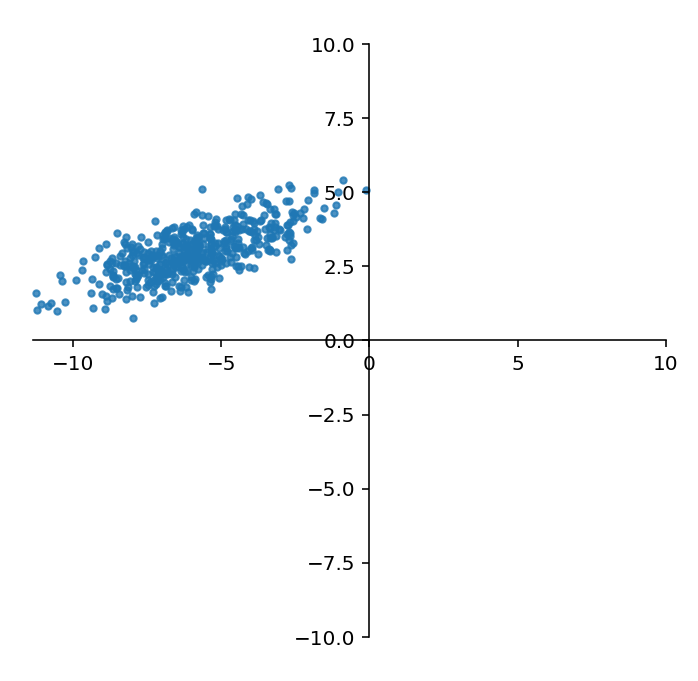

In [3]:
n_samples = 500
C = np.array([[0.1, 0.6], [2., .6]])
X = np.random.randn(n_samples, 2) @ C + np.array([-6, 3])
ax = ut.plotSetup(-10,10,-10,10,(6,6))
ut.centerAxes(ax)
plt.axis('equal')
_ = plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.8)

What would happen if we used SVD, and kept only rank-1 approximation to the data?

This would be the 1-D __subspace__ that approximates the data best.   

However the variance in the data is defined with respect to the data mean, so we need to mean-center the data first, before using SVD.

That is, SVD in this case finds the best 1-D subspace, not the best line though the data (which might not pass through the origin).

So to capture the best line through the data, we first move the data points to the origin:

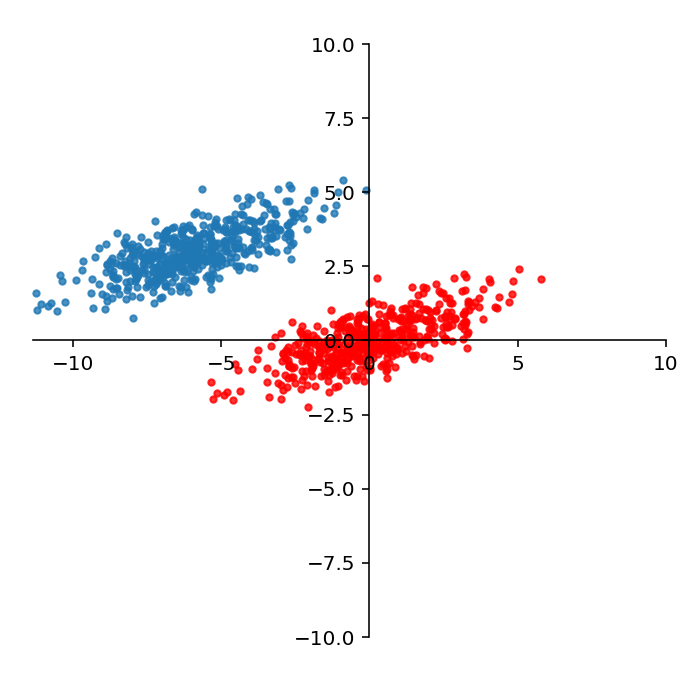

In [4]:
Xc = X - np.mean(X,axis=0)
ax = ut.plotSetup(-10,10,-10,10,(6,6))
ut.centerAxes(ax)
plt.axis('equal')
plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.8)
_ = plt.scatter(Xc[:, 0], Xc[:, 1], s=10, alpha=0.8, color='r')

Now let's construct the best 1-D approximation of the mean-centered data:

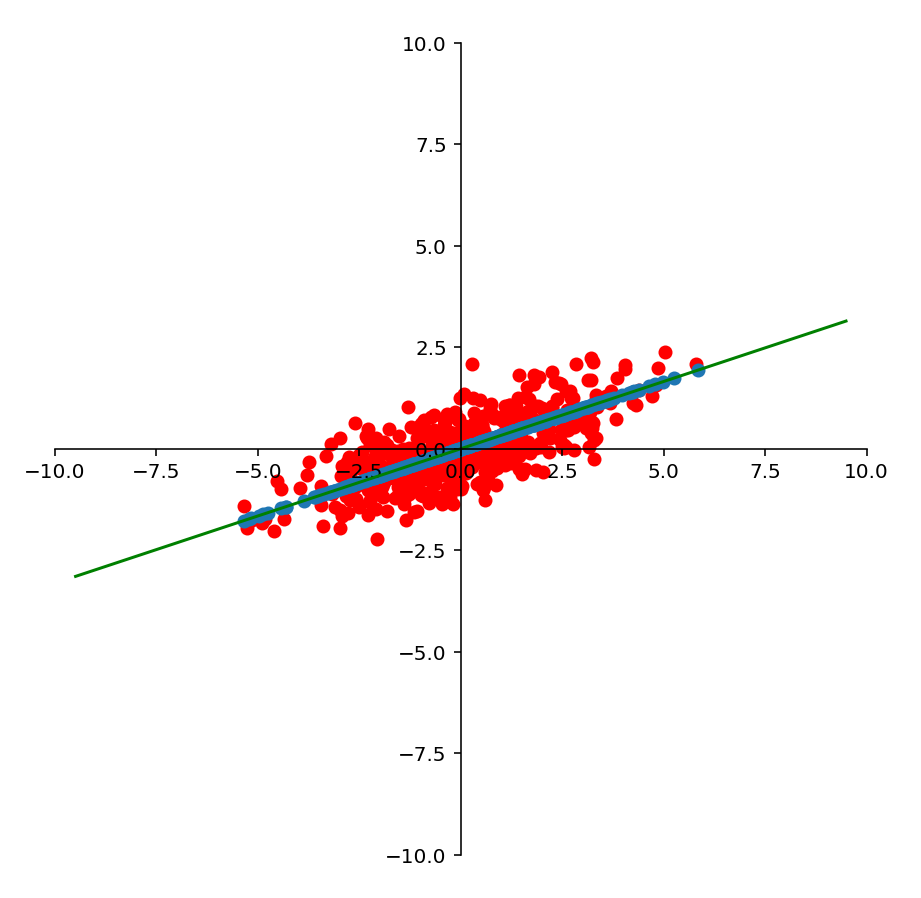

In [5]:
u, s, vt = np.linalg.svd(Xc,full_matrices=False)
scopy = s.copy()
scopy[1] = 0.
reducedX = u @ np.diag(scopy) @ vt
ax = ut.plotSetup(-10,10,-10,10,(8,8))
ut.centerAxes(ax)
plt.axis('equal')
plt.scatter(Xc[:,0],Xc[:,1], color='r')
plt.scatter(reducedX[:,0], reducedX[:,1])
endpoints = np.array([[-10],[10]]) @ vt[[0],:]
_ = plt.plot(endpoints[:,0], endpoints[:,1], 'g-')

This method is called __Principal Component Analysis.__

In summary, PCA consists of:

1. Mean center the data, and
2. Reduce the dimension of the mean-centered data via SVD.

This is equivalent to projecting the data onto the subspace that captures the maximum variance in the data.

It winds up constructing the __best low dimensional approximation of the data.__

What are "principal components"?

These are nothing more than the columns of $U$ (or the rows of $V^T$).  Because they capture the direction of maximum variation, they are called "principal" components.

## Uses of PCA/SVD

There are many uses of PCA (and SVD).

We'll cover three of the main uses:

1. Visualization
2. Denoising
3. Anomaly Detection

As already mentioned, SVD is also useful for data compression -- we won't discuss it in detail, but it is the principle behind audio and video compression (MP3s, HDTV, etc).

## Visualization and Denoising -- Extended Example.

We will study both visualization and denoising in the context of text processing.

As we have seen, a common way to work with documents is using the bag-of-words model (perhaps considering n-grams), which results in a term-document matrix.

Entries in the matrix are generally TF-IDF scores.

$f_{ij}$: Frequency of term $i$ in document $j$

$$\text{TF}_{ij}=\frac{f_{ij}}{\max_k f_{kj}}$$

$n_i$: number of documents that mention term $i$

$N$: total number of documents

$$\text{IDF}_i=\log\frac{N}{n_i}$$

$\text{TF.IDF}$ score: $w_{ij}=\text{TF}_{ij}\times \text{IDF}_i$

document profile: set of words with high TF.IDF scores.

Often, terms are correlated -- they appear together in combinations that suggest a certain "concept".

That is, term-document matrices often show low effective rank -- many columns can be approximated as combinations of other columns.

When PCA is used for dimensionality reduction of documents, it tends to to extract these "concept" vectors.

The application of PCA to term-document matrices is called __Latent Semantic Analysis (LSA).__

Among other benefits, LSA can improve the performance of clustering of documents.

This happens because the important concepts are captured in the most significant principal components.

## Data: 20 Newsgroups

In [6]:
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.os.ms-windows.misc', 'sci.space','rec.sport.baseball']
news_data = fetch_20newsgroups(subset='train', categories=categories)

In [7]:
print(news_data.target_names)
print(news_data.target)

#import nltk
#nltk.download()

['comp.os.ms-windows.misc', 'rec.sport.baseball', 'sci.space']
[2 0 0 ... 2 1 2]


In [11]:
#import nltk
#nltk.download()

To get started, let's compute tf-idf scores.

Notice that we will let the tokenizer compute $n$-grams for $n=$1 and 2.  

An $n$-gram is a set of $n$ consecutive terms.

We'll compute a document-term matrix `dtm`.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=4,max_df=0.8)
dtm = vectorizer.fit_transform(news_data.data)

In [13]:
print(type(dtm), dtm.shape)
terms = vectorizer.get_feature_names()
print(terms)

<class 'scipy.sparse.csr.csr_matrix'> (1781, 9409)
['00', '000', '0005', '0062', '0096b0f0', '00bjgood', '00mbstultz', '01', '0114', '01wb', '02', '02138', '023017', '024222', '03', '033', '0362', '03k', '04', '0400', '05', '051746', '06', '0688', '07', '08', '086', '09', '091051', '093231', '0_', '0a', '0b', '0c', '0d', '0e', '0ek', '0f', '0g', '0h', '0hd', '0i', '0iv', '0j', '0k', '0l', '0m', '0m75u', '0n', '0o', '0p', '0q', '0qax', '0qq', '0r', '0s', '0t', '0tbxn', '0tbxom', '0tq', '0tq6', '0u', '0v', '0va', '0w', '0x', '0y', '0z', '10', '100', '1000', '100m', '101', '101044', '102', '1024x768', '1024x768x256', '103', '104', '105', '106', '107', '108', '109', '11', '110', '1100', '111', '11181', '112', '113', '114', '115', '115313', '117', '118', '119', '11th', '12', '120', '1200', '120399', '121', '122', '123', '124', '125', '126', '127', '128', '1280x1024', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '13p', '13q', '13qs', '13s', '14', '140', 

### Improvement: Stemming

One source of noise that we can eliminate (before we use LSA) comes from word endings.

For example: a Google search on 'run' will return web pages on 'running.'

This is useful, because the difference between 'run' and 'running' in practice is not enough to matter.

The usual solution taken is to simply 'chop off' the part of the word that indicates a variation from the base word.

(For those of you who studied Latin or Greek, this will sound familiar -- we are removing the 'inflection.')

The process is called 'stemming.'

A very good stemmer is the "Snowball" stemmer.

You can read more at http://www.nltk.org and http://www.nltk.org/howto/stem.html.

Installation Note: From a cell you need to call `nltk.download()` and select the appropriate packages from the interface that appears. In particular you need to download: `stopwords` from _corpora_ and `punkt` and `snowball_data` from _models._

Let's stem the data using the Snowball stemmer:

In [14]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize


stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
         for sent in sent_tokenize(message)
        for word in word_tokenize(sent))
        for message in news_data.data]

# stemmed_data = news_data.data

In [15]:
dtm = vectorizer.fit_transform(stemmed_data)
terms = vectorizer.get_feature_names()
print(terms)

['00', '000', '0005', '0062', '0096b0f0', '00bjgood', '00mbstultz', '01', '0114', '01wb', '02', '02138', '023017', '024222', '03', '033', '0362', '03i', '03k', '04', '0400', '05', '051746', '06', '0688', '07', '08', '086', '09', '091051', '093231', '0_', '0a', '0b', '0c', '0d', '0e', '0ek', '0f', '0g', '0h', '0hd', '0i', '0iv', '0j', '0k', '0l', '0m', '0m75u', '0n', '0o', '0p', '0q', '0qax', '0qq', '0r', '0s', '0t', '0tbxn', '0tbxom', '0tq', '0tq6', '0u', '0v', '0va', '0w', '0x', '0y', '0z', '10', '100', '1000', '100m', '101', '101044', '102', '1024x768', '1024x768x256', '103', '104', '105', '106', '107', '108', '109', '11', '110', '1100', '111', '11181', '112', '113', '114', '115', '115313', '117', '118', '119', '11th', '12', '120', '1200', '120399', '121', '122', '123', '124', '125', '126', '127', '128', '1280x1024', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '13p', '13q', '13qs', '13s', '14', '140', '1400', '141', '141824', '142', '143', '144'

## Demonstrating PCA

OK.  Now, let's apply PCA.

Our data matrix is in sparse form.



First, we mean center the data.
Note that `vectors` is a sparse matrix, but once it is mean centered it is not sparse any longer.

In [16]:
dtm_dense = dtm.todense()
centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)
np.sum(centered_dtm,axis=0)[:,:10]

matrix([[-6.09234885e-15, -7.81406190e-15,  1.43851944e-15,
          3.68368530e-15,  5.22748077e-15, -1.69146381e-15,
         -2.70269918e-15,  4.54801127e-15,  6.43365569e-15,
          4.45254727e-15]])

In [17]:
u, s, vt = np.linalg.svd(centered_dtm)

Note that if you have sparse data, you may want to use `scipy.sparse.linalg.svds()` and for large data it may be advantageous to use `sklearn.decomposition.TruncatedSVD()`.

$$ \mbox{objects}\left\{\begin{array}{c}\;\\\;\\\;\\\;\\\;\end{array}\right.\;\;\overbrace{\left[\begin{array}{cccc}\begin{array}{c}\vdots\\\vdots\\{\bf a_1}\\\vdots\\\vdots\end{array}&\begin{array}{c}\vdots\\\vdots\\{\bf a_2}\\\vdots\\\vdots\end{array}&\dots&\begin{array}{c}\vdots\\\vdots\\{\bf a_n}\\\vdots\\\vdots\end{array}\\\end{array}\right]}^{\mbox{features}} =
\overbrace{\left[\begin{array}{cc}\vdots&\vdots\\\vdots&\vdots\\\sigma_1\vu_1&\sigma_k\vu_k\\\vdots&\vdots\\\vdots&\vdots\end{array}\right]}^{\large k}
\times
\left[\begin{array}{ccccc}\dots&\dots&\vv_1&\dots&\dots\\\dots&\dots&\vv_k&\dots&\dots\end{array}\right]$$


$$ A = U\Sigma V^T$$

The principal components (rows of $V^T$) encode the extracted concepts.

Each LSA __concept__ is a linear combination of words.

In [18]:
pd.DataFrame(vt,columns=vectorizer.get_feature_names())

,00,000,0005,0062,0096b0f0,00bjgood,00mbstultz,01,0114,01wb,...,zri,zrlk,zs,zt,zu,zv,zw,zx,zy,zz
0,0.007885,0.012338,0.000590,0.005540,0.001029,0.002068,0.002007,0.005579,0.001241,0.000814,...,-0.000028,-0.000025,-0.000194,-0.000025,-0.000129,-0.000207,-0.000087,-0.000151,-0.000113,0.000532
1,-0.005887,0.009506,0.002096,-0.010692,-0.001650,-0.003485,-0.002692,0.002124,-0.003395,0.002451,...,-0.000015,-0.000013,-0.000048,-0.000013,-0.000042,-0.000099,-0.000025,-0.000062,-0.000040,-0.001043
2,-0.012562,-0.012011,-0.002483,0.001447,0.000431,0.000051,0.000349,-0.006842,0.000692,-0.001129,...,-0.000096,-0.000087,-0.000270,-0.000087,-0.000253,-0.000579,-0.000134,-0.000294,-0.000205,-0.000015
3,0.013522,0.017799,0.003623,0.000993,0.003338,-0.000427,0.000616,0.011659,0.002225,0.001975,...,0.000205,0.000186,0.000452,0.000172,0.000465,0.001143,0.000221,0.000509,0.000353,0.000210
4,-0.002048,-0.007633,-0.005712,0.001727,0.000315,0.000814,0.000187,-0.002988,-0.000075,0.001228,...,-0.000246,-0.000224,-0.000611,-0.000208,-0.000581,-0.001387,-0.000283,-0.000619,-0.000447,-0.001012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8055,0.000040,-0.001031,0.000275,-0.000183,-0.001272,-0.000034,-0.000240,0.001217,0.000218,-0.000059,...,-0.001382,-0.001953,-0.000361,-0.001174,0.000919,0.975836,-0.000092,0.000067,-0.000105,0.000555
8056,0.000069,0.000216,-0.000055,-0.000114,-0.000126,0.000061,0.000018,-0.000524,-0.000041,-0.000088,...,0.000107,0.000098,-0.000655,-0.000146,-0.001075,-0.000140,0.999353,-0.000481,-0.000754,-0.000856
8057,-0.000019,0.000847,0.000148,-0.000035,-0.000823,0.000005,-0.000033,-0.000519,0.000007,-0.000298,...,0.000252,0.000215,-0.001012,-0.000185,-0.000828,0.000160,-0.000496,0.996899,-0.001099,0.000810
8058,0.000057,0.000479,-0.000012,-0.000170,-0.000429,0.000080,-0.000016,-0.000806,-0.000099,-0.000166,...,0.000191,0.000176,-0.000684,-0.000266,-0.001193,-0.000172,-0.000751,-0.001131,0.998734,-0.000762


The rows of $U$ correpond to documents, which are linear combinations of __concepts__.

## Denoising

In order to improve our representation, we will __exclude__ the less significant concepts from the documents' feature vectors.

That is, we will choose the leftmost $k$ columns of $U$ and the topmost $k$ rows of $V^T$.  

The reduced set of columns of $U$ are our new document encodings, and it is those that we will cluster.

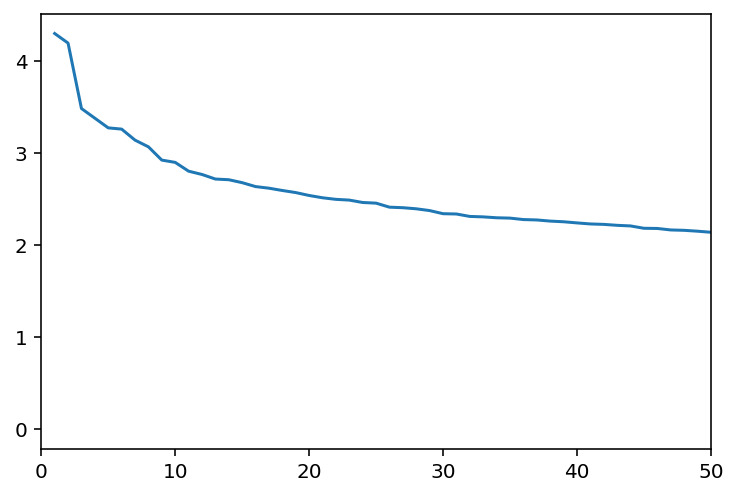

In [19]:
plt.xlim([0,50])
plt.plot(range(1,len(s)+1),s)

It looks like 2 is a reasonable number of principal components.

## Visualization

That's a good thing, because it means that we can __visualize__ the data well with the help of PCA.

Recall that the challenge of visualization is that the data live in a high dimensional space.  

We can only look at 2 (or maybe 3) dimensions at a time, so it's not clear __which__ dimensions to look at.

The idea behind using PCA for visualization is that since low-numbered principal components capture most of the __variance__ in the data, these are the "directions" from which it is most useful to inspect the data.

We saw that the first two principal components were particularly large -- let's start by using them for visualization.

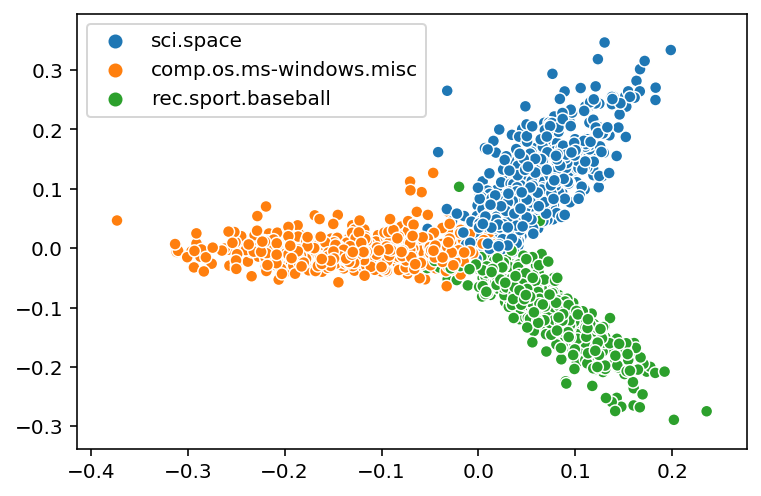

In [40]:
k=2
vectorsk = np.array(u[:,:k] @ np.diag(s[:k]))
labels = [news_data.target_names[i] for i in news_data.target]
sns.scatterplot(x=vectorsk[:,0], y=vectorsk[:, 1], hue=labels)

What about the other principal components?   Are they useful for visualization?

A common approach is to look at all pairs of (low-numbered) principal components.

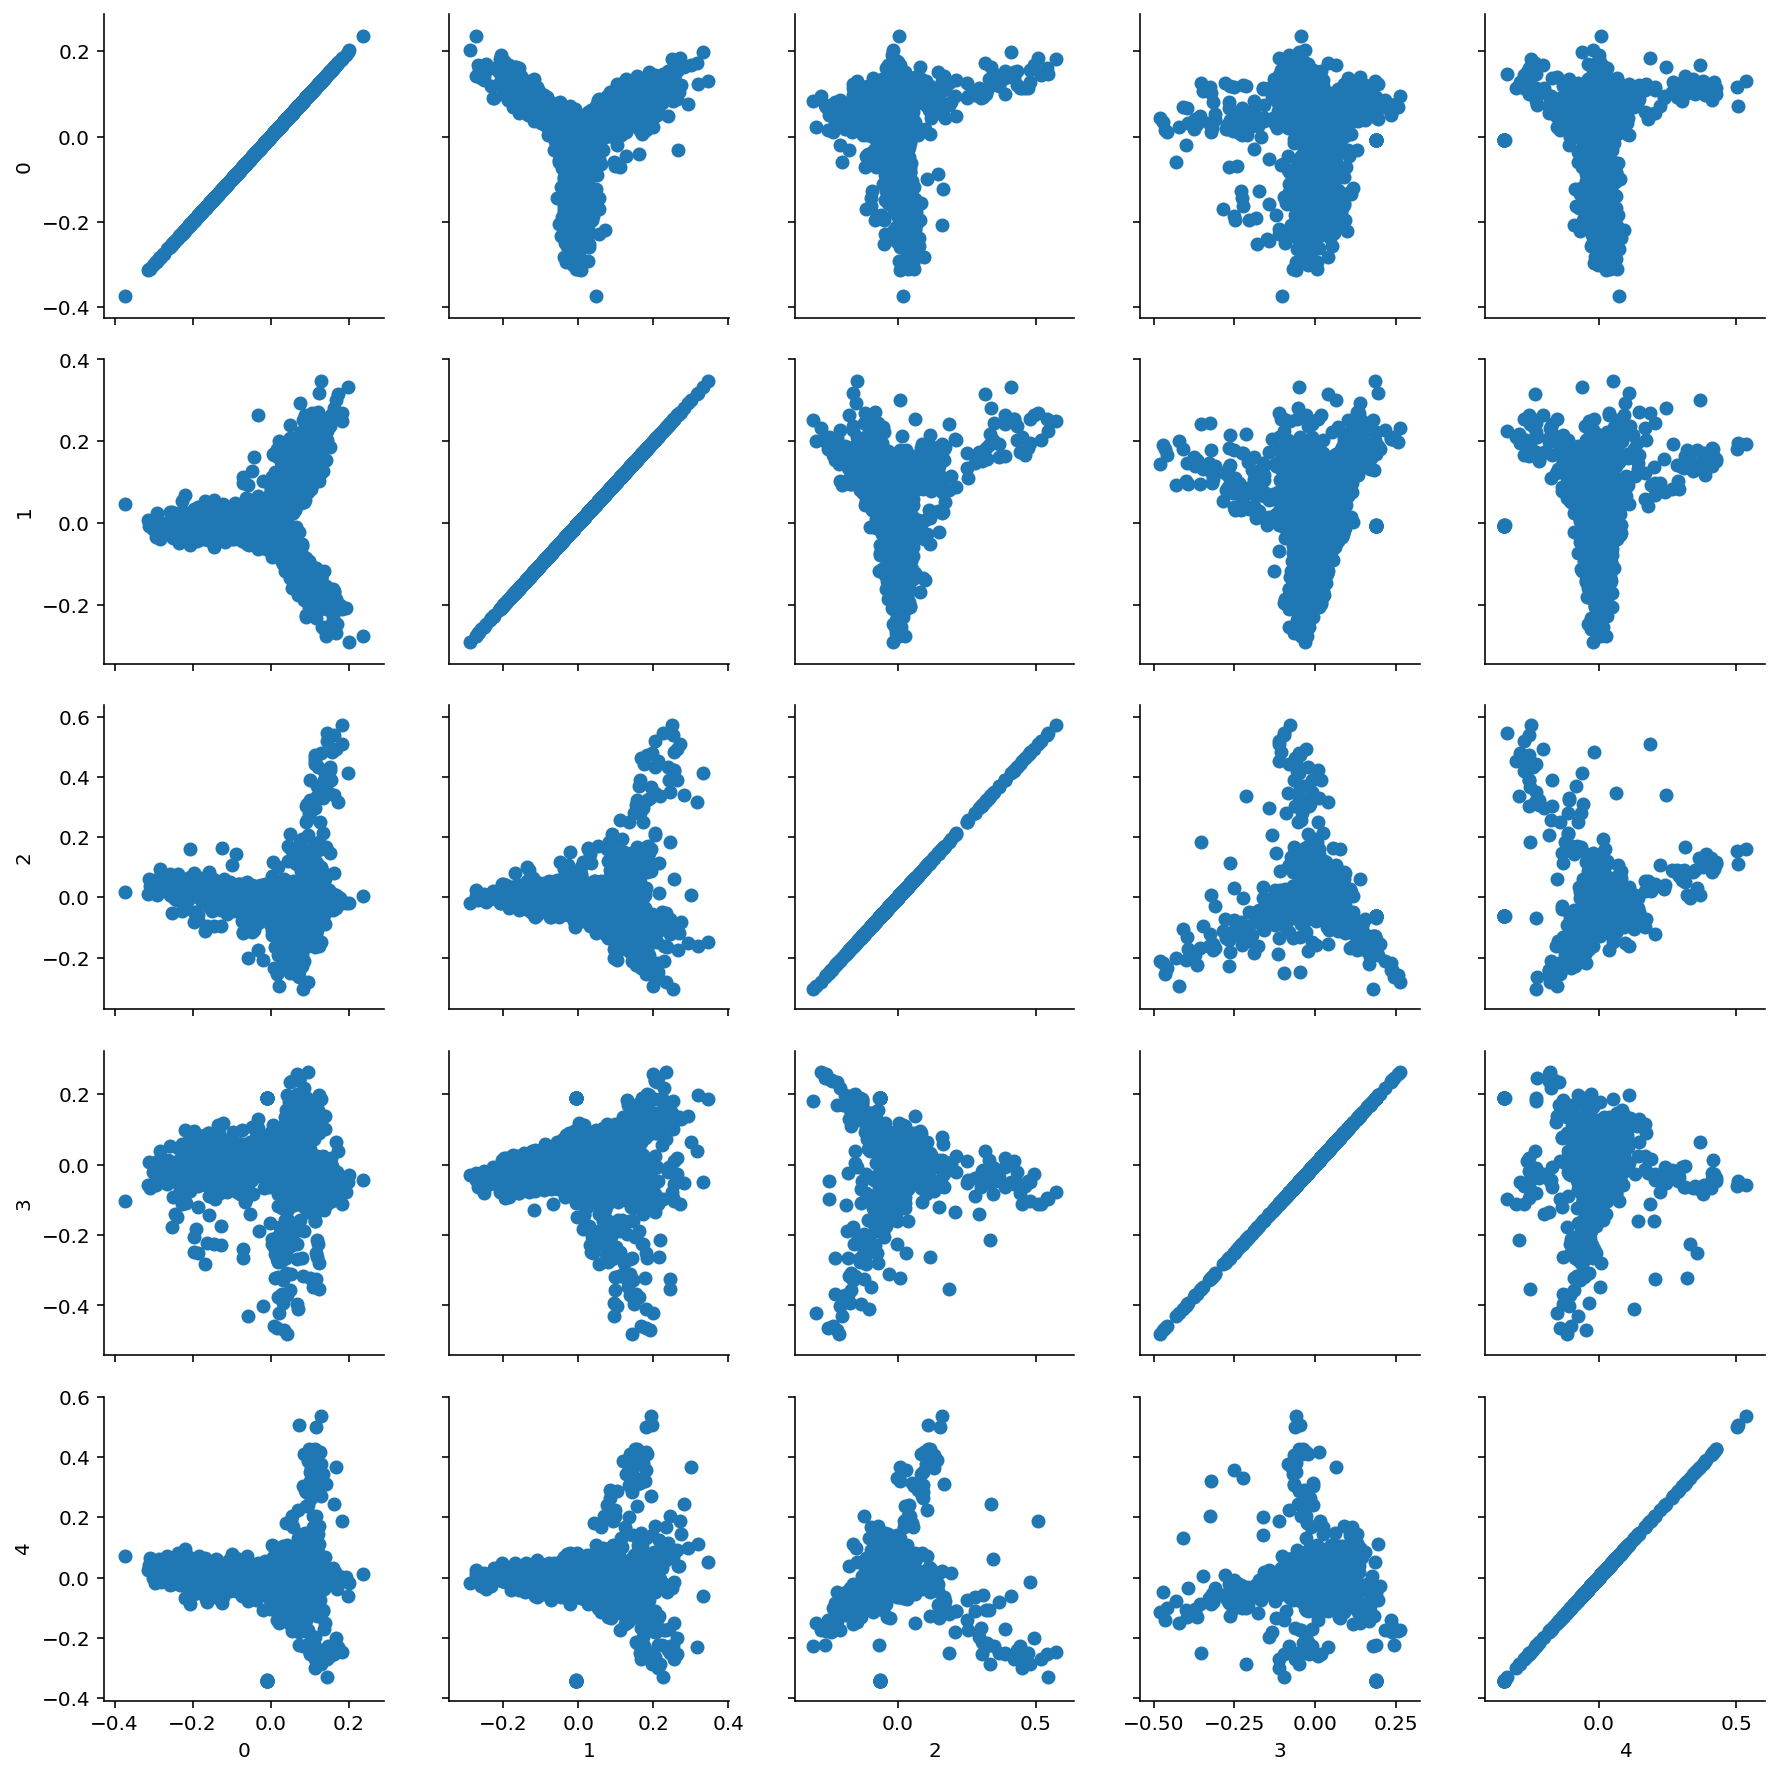

In [41]:
import seaborn as sns
k = 5
Xk = u[:,:k] @ np.diag(s[:k])
X_df = pd.DataFrame(Xk)
g = sns.PairGrid(X_df)
g.map(plt.scatter)

## Looking at the Topics

In [42]:
for i in range(6):
    top = np.argsort(vt[i])
    topterms = [terms[top[0,f]] for f in range(12)]
    print (i, topterms)

0 ['window', 'file', 'driver', 'dos', 'use', 'card', 'font', 'ms', 'problem', 'program', 'mous', 'nt']
1 ['game', 'team', 'player', 'pitch', 'run', 'basebal', 'win', 'hit', 'edu', 'score', 'year', 'play']
2 ['access', 'nasa', 'digex', 'pat', 'gov', 'jpl', 'baalk', 'com', '___', 'kelvin', '__', 'prb']
3 ['access', 'digex', 'pat', 'com', 'prb', 'net', 'express', 'onlin', 'communic', 'usa', 'dseg', 'ti']
4 ['ax', 'henri', 'toronto', 'zoo', 'com', 'spencer', 'zoolog', 'access', 'jpl', 'baalk', 'orbit', 'digex']
5 ['window', 'run', 'nasa', 'year', 'file', 'team', 'game', 'win', 'dos', 'hit', 'henri', 'orbit']
